# Project Overview

Tanzania, as a developing country, struggles with providing clean water to its population of over 57,000,000. There are many waterpoints already established in the country, but some are in need of repair while others have failed altogether.

Can you predict which water pumps are faulty?

Using data from Taarifa and the Tanzanian Ministry of Water, can you predict which pumps are functional, which need some repairs, and which don't work at all? This is an intermediate-level practice competition. Predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.

Build a classifier to predict the condition of a water well, using information about the sort of pump, when it was installed, etc. Note that this is a ternary classification problem.

<a href="https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/">Tanzanian Water Well Data</a>
 
This dataset is part of an active competition until April 31, 2021!



## Import packages

In [2]:
import pandas as pd
import numpy as np
import sys
import zipfile
import folium
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point
from matplotlib import ticker
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, ParameterGrid
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import Lasso, Ridge, LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, ExtraTreesClassifier, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from mlxtend.classifier import StackingClassifier

## Data

#### Import Data

In [3]:
X = pd.read_csv("../../references/training_set_values.csv", index_col = 'id')

In [4]:
y = pd.read_csv("../../references/training_set_labels.csv", index_col = 'id')['status_group']

In [5]:
unlabeled_df = pd.read_csv("../../references/test_set_values.csv", index_col = 'id')

#### Feature info

<a href="https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/">Link to information about features</a>

In [6]:
# amount_tsh - Total static head (amount water available to waterpoint)
# date_recorded - The date the row was entered - do not include
# funder - Who funded the well
# gps_height - Altitude of the well
# installer - Organization that installed the well
# longitude - GPS coordinate - do not include
# latitude - GPS coordinate - do not include
# wpt_name - Name of the waterpoint if there is one
# num_private -
# basin - Geographic water basin
# subvillage - Geographic location
# region - Geographic location
# region_code - Geographic location (coded)
# district_code - Geographic location (coded)
# lga - Geographic location
# ward - Geographic location
# population - Population around the well
# public_meeting - True/False - ?
# recorded_by - Group entering this row of data
# scheme_management - Who operates the waterpoint
# scheme_name - Who operates the waterpoint
# permit - If the waterpoint is permitted
# construction_year - Year the waterpoint was constructed
# extraction_type - The kind of extraction the waterpoint uses
# extraction_type_group - The kind of extraction the waterpoint uses
# extraction_type_class - The kind of extraction the waterpoint uses
# management - How the waterpoint is managed
# management_group - How the waterpoint is managed
# payment - What the water costs
# payment_type - What the water costs
# water_quality - The quality of the water
# quality_group - The quality of the water
# quantity - The quantity of water
# quantity_group - The quantity of water
# source - The source of the water
# source_type - The source of the water
# source_class - The source of the water
# waterpoint_type - The kind of waterpoint
# waterpoint_type_group - The kind of waterpoint

### Maps

#### Scatter Plot of Wells

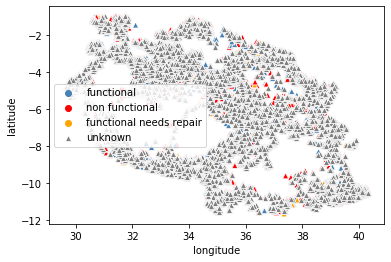

In [7]:
df_loc = X.join(y)[['longitude', 'latitude', 'status_group']]
df_loc = df_loc[df_loc['longitude']!=0]
df_loc.status_group.value_counts()

sns.scatterplot(data=df_loc, x = 'longitude', y = 'latitude', marker = '^', alpha = 1,
                hue = df_loc.status_group.tolist(), palette = ['steelblue', 'red', 'orange'])


test_df_loc = unlabeled_df[['longitude', 'latitude']]
test_df_loc = test_df_loc[test_df_loc['longitude']!=0]
test_df_loc['status_group'] = 'unknown'
sns.scatterplot(data = test_df_loc, x = 'longitude', y = 'latitude', marker= "^", color = 'grey', label = 'unknown');

#### Import shape files for Tanzania

In [8]:
# Uncomment to download shapefiles
# ! wget -P ../../data http://stacks.stanford.edu/file/druid:tn398yw9512/data.zip

In [9]:
# Uncomment to unzip shapefiles
# with zipfile.ZipFile('../../data/data.zip', 'r') as zip_ref:
#     zip_ref.extractall('../../data/shapefiles')

#### Create GeoDataFrames from Data
Convert crs from 4326 to 3857 (changes latitude and logitude format for plotting)

In [10]:
geo_df = gpd.read_file('../../data/shapefiles/TAN.shp')
geo_df = geo_df.to_crs(epsg = 3857)

C:\Users\Sin City\anaconda3\envs\learn-env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [11]:
# Add a geometry column that holds Point objects with lat and long
df_loc['geometry'] = df_loc.apply(lambda x: Point(float(x.longitude), float(x.latitude)), axis=1)
gdf = gpd.GeoDataFrame(df_loc, geometry='geometry')
gdf.crs = "EPSG:4326"
gdf = gdf.to_crs(epsg = 3857)

C:\Users\Sin City\anaconda3\envs\learn-env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [12]:
# Add a geometry column that holds Point objects with lat and long
test_df_loc['geometry'] = test_df_loc.apply(lambda x: Point(float(x.longitude), float(x.latitude)), axis=1)
gdf_test = gpd.GeoDataFrame(test_df_loc, geometry='geometry')
gdf_test.crs = "EPSG:4326"
gdf_test = gdf_test.to_crs(epsg = 3857)

C:\Users\Sin City\anaconda3\envs\learn-env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


#### Create Folium map to show where Tanzania is

In [13]:
m = folium.Map(location=[-6.3690, 34.8888], zoom_start = 5)
m.choropleth(geo_data=geo_df, fill_color='blue', fill_opacity=0.2, line_opacity=.1)
display(m)

C:\Users\Sin City\anaconda3\envs\learn-env\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning
C:\Users\Sin City\anaconda3\envs\learn-env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


#### Geopandas plots with Contextly

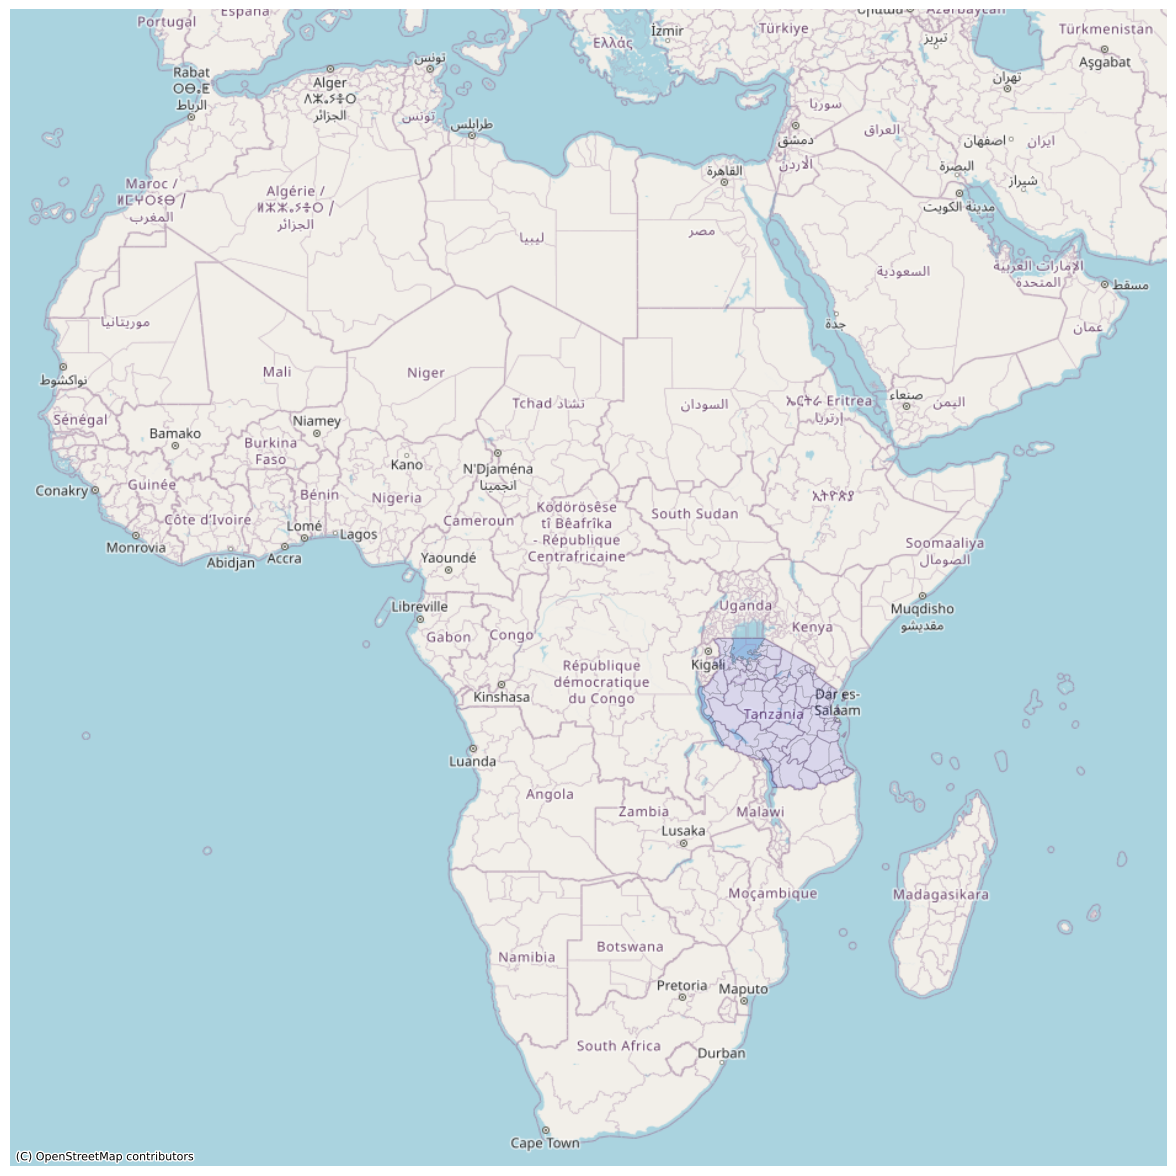

In [14]:
plt.style.use('default')
sns.set_context("paper", font_scale=1.5)

fig, ax = plt.subplots(figsize=(12,12))
geo_df.plot(ax=ax, color = 'blue', edgecolor = 'k', alpha = .1)

minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx-5500000, maxx+2500000)
ax.set_ylim(miny-3000000, maxy+5000000)

ctx.add_basemap(ax, source = ctx.providers.OpenStreetMap.Mapnik) #source=ctx.providers.OpenStreetMap.Mapnik) lots of styles to choose from
# plt.title('Tanzanian Water Wells')

ax.set_axis_off()
fig.tight_layout()
plt.savefig('../../reports/figures/Africa.jpg');

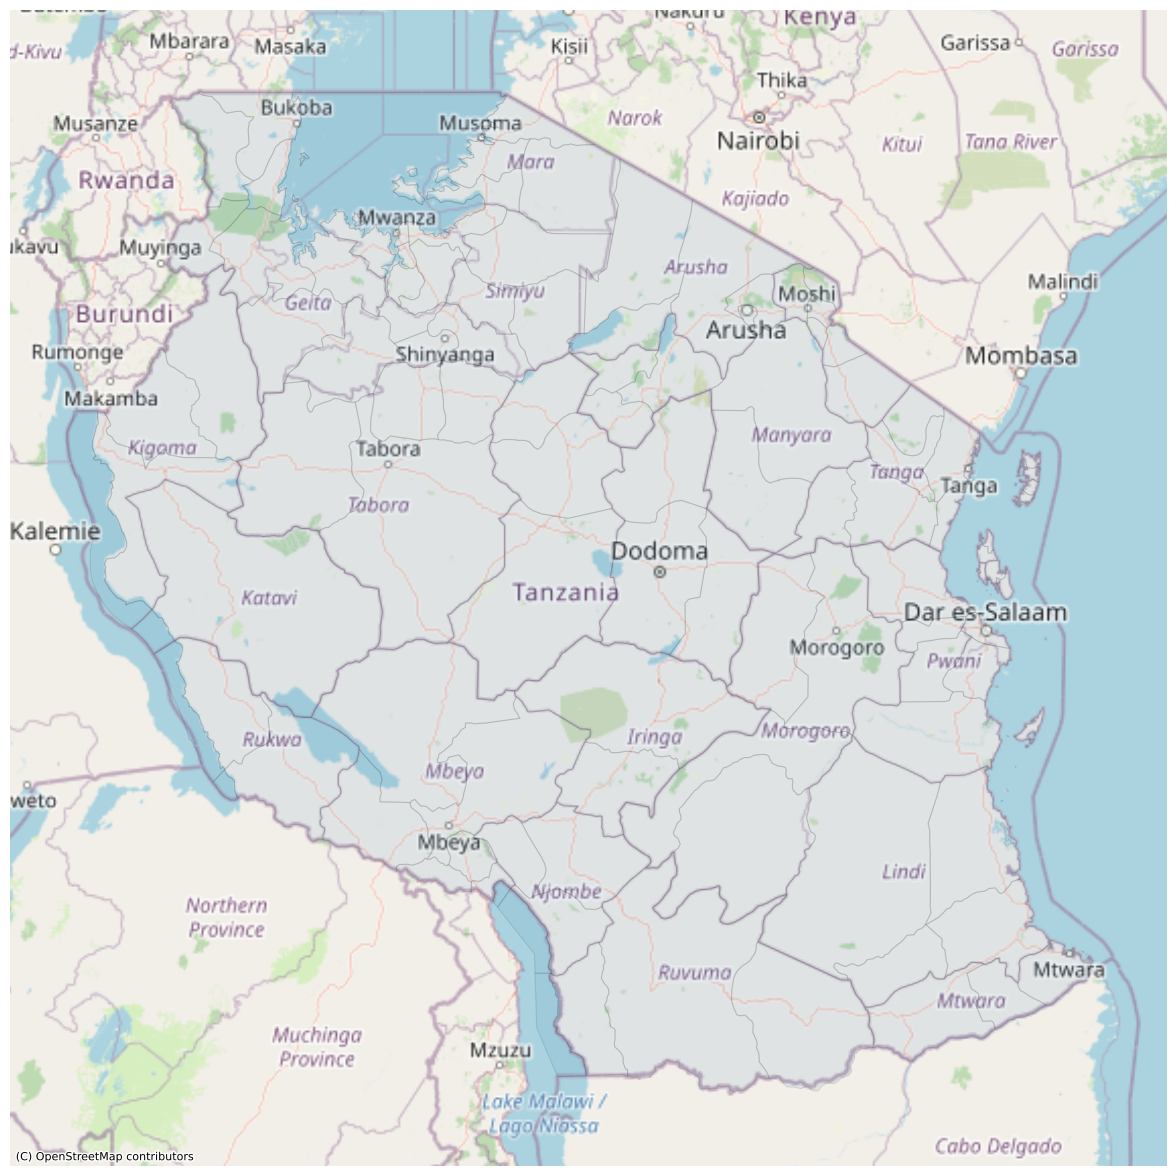

In [15]:
plt.style.use('default')
sns.set_context("paper", font_scale=1.5)

fig, ax = plt.subplots(figsize=(12,12))
geo_df.plot(ax=ax, color = 'steelblue', edgecolor = 'k', alpha = .1)

minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx-100000, maxx+100000)
ax.set_ylim(miny-100000, maxy+100000)

ctx.add_basemap(ax, source = ctx.providers.OpenStreetMap.Mapnik) #source=ctx.providers.OpenStreetMap.Mapnik) lots of styles to choose from
# plt.title('Tanzania', fontdict={'fontsize': '50', 'fontweight' : '10', 'color' : 'coral'})

ax.set_axis_off()
fig.tight_layout()
plt.savefig('../../reports/figures/Tanzania.jpg', dpi = 300);

#### Add Wells + Status to Plot

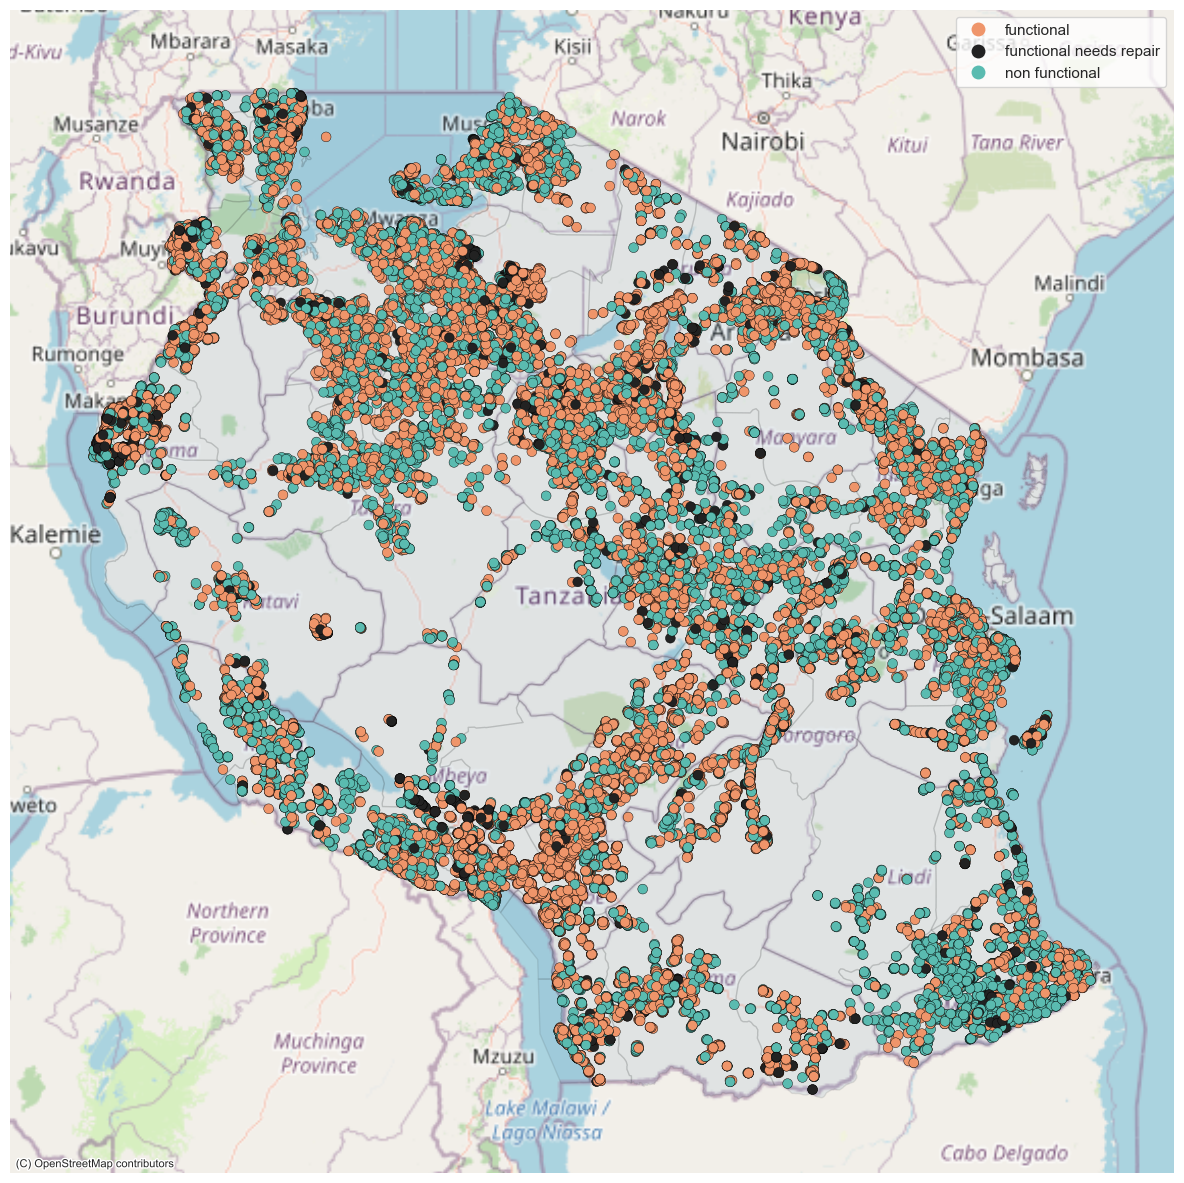

In [284]:
sns.set_context(font_scale=2)

fig, ax = plt.subplots(figsize=(12,12))

geo_df.plot(ax=ax, color = 'steelblue', edgecolor = 'k', alpha = .1)

custom_palette = sns.diverging_palette(30, 180, l=70, center="dark", as_cmap=True)

# sns.color_palette(palette=[], n_colors=None, desat=None, as_cmap=False)

gdf.plot(ax=ax, column = 'status_group', marker = '.', markersize=200,
         edgecolor = 'black', cmap = custom_palette,
         linewidth=.3, legend = True)

minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx-100000, maxx+100000)
ax.set_ylim(miny-100000, maxy+100000)

ctx.add_basemap(ax, source = ctx.providers.OpenStreetMap.Mapnik)#, source=ctx.providers.OpenStreetMap.Mapnik)
# plt.title('Tanzanian Water Wells', fontdict={'fontsize': '50', 'fontweight' : '10', 'color' : 'coral'})

ax.set_axis_off()
fig.tight_layout()
plt.savefig('../../reports/figures/Tanzania_train.jpg', dpi = 300);

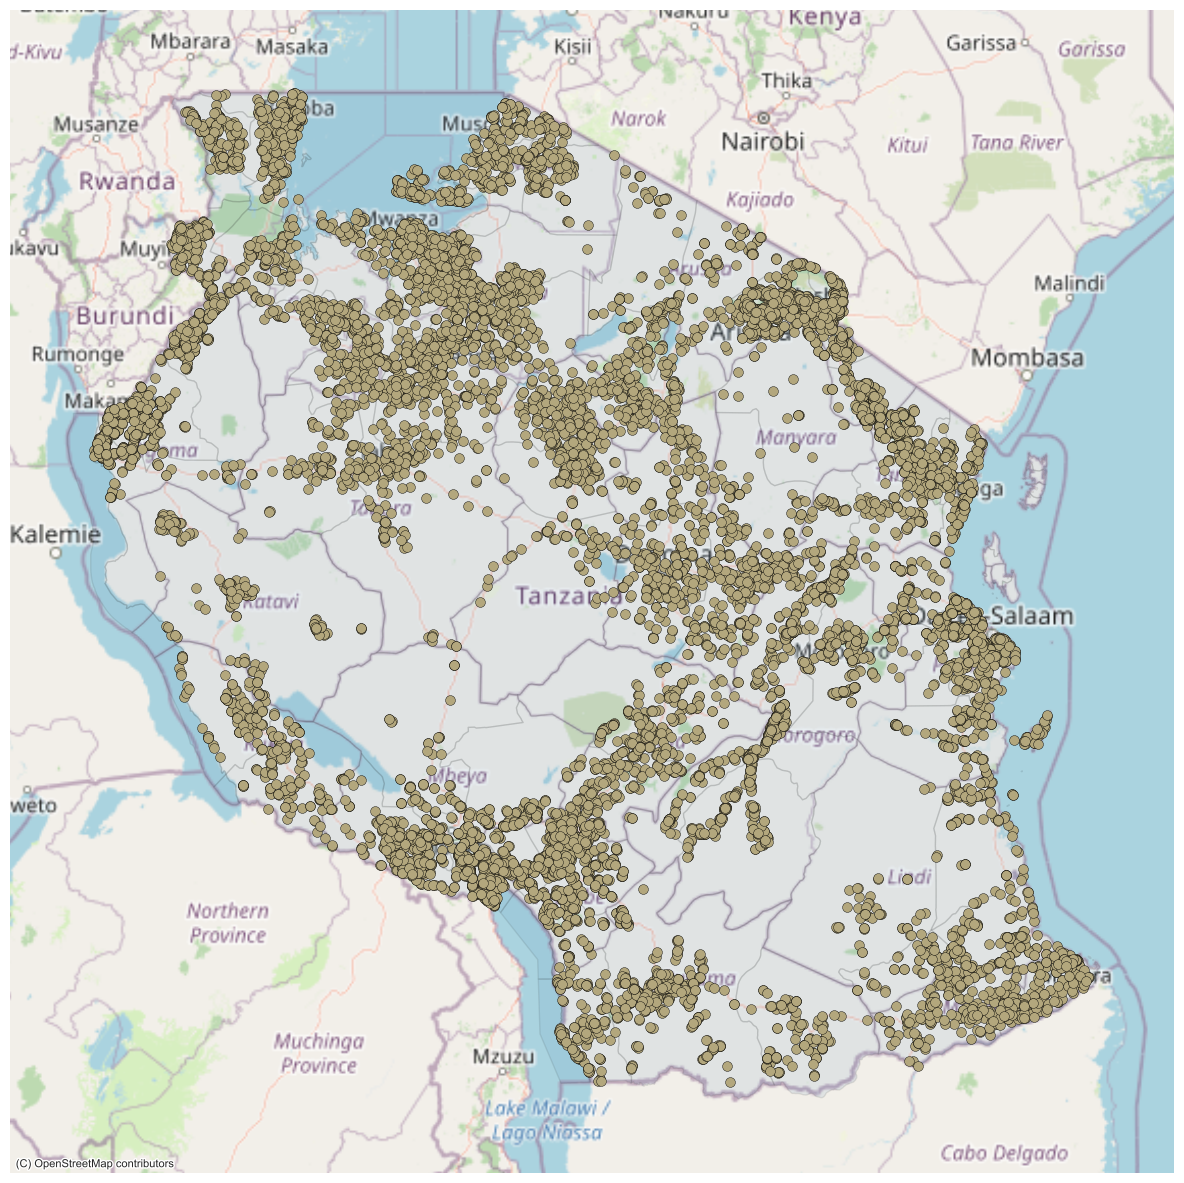

In [283]:
fig, ax = plt.subplots(figsize=(12,12))
geo_df.plot(ax=ax, color = 'steelblue', edgecolor = 'k', alpha = .1)

gdf_test.plot(ax=ax, marker = '.', markersize=200, color='#B3A77D',
              edgecolor = 'black', linewidth=.3, legend = True)

minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx-100000, maxx+100000)
ax.set_ylim(miny-100000, maxy+100000)

ctx.add_basemap(ax, source = ctx.providers.OpenStreetMap.Mapnik)#, source=ctx.providers.OpenStreetMap.Mapnik)
# plt.title('Tanzanian Water Wells', fontdict={'fontsize': '50', 'fontweight' : '10', 'color' : 'coral'})
ax.set_axis_off()
fig.tight_layout()
plt.savefig('../../reports/figures/Tanzania_test.jpg', dpi = 300);

### Data Cleaning

#### Drop Date and NA and unique identifier columns for now

In [18]:
# X.info()

In [19]:
columns_with_na = ['permit', 'scheme_name', 'public_meeting', 'subvillage', 'installer', 'funder']
X.drop(columns_with_na, axis=1, inplace=True)

In [20]:
columns_with_specific_location_and_names = ['ward', 'wpt_name']
X.drop(columns_with_specific_location_and_names, axis=1, inplace=True)

In [21]:
X.drop('date_recorded', axis=1, inplace=True)

#### Fill scheme_management column NAs with "unknown"

In [22]:
X['scheme_management'].value_counts()

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [23]:
X['scheme_management'] = X['scheme_management'].fillna("UNKNOWN")

In [24]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 30 columns):
amount_tsh               59400 non-null float64
gps_height               59400 non-null int64
longitude                59400 non-null float64
latitude                 59400 non-null float64
num_private              59400 non-null int64
basin                    59400 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
population               59400 non-null int64
recorded_by              59400 non-null object
scheme_management        59400 non-null object
construction_year        59400 non-null int64
extraction_type          59400 non-null object
extraction_type_group    59400 non-null object
extraction_type_class    59400 non-null object
management               59400 non-null object
management_group         59400 non-null obje

In [25]:
X['scheme_management'].value_counts()

VWC                 36793
WUG                  5206
UNKNOWN              3877
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

### EDA Visuals

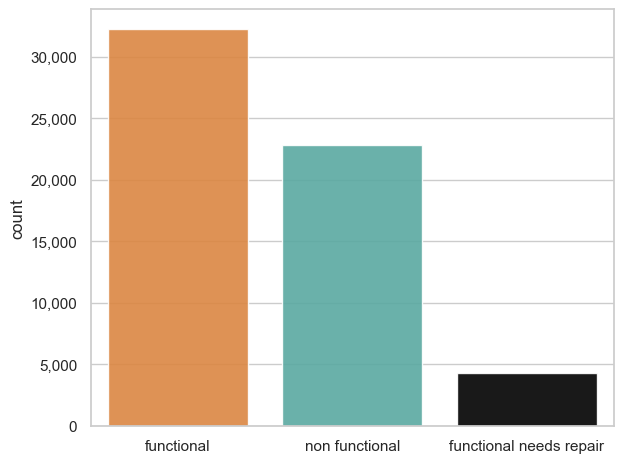

In [163]:
plt.style.use('default')
sns.set(context = 'notebook', style = 'whitegrid')
colors = ["#F48328", "#4DB6AC", "black"]

my_palette = sns.color_palette(colors)

fig, ax = plt.subplots() 
# ax.yaxis.grid(alpha=.25) # horizontal lines

# ax.hist(y, bins = 5)
# ax.set_title('Well Status Distribution', fontdict={'fontsize': '25', 'fontweight' : '30', 'color' : 'black'})

sns.countplot(y, palette=my_palette, alpha=.9)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set(xlabel=None)
fig.tight_layout()
plt.savefig('../../reports/figures/Well_status_dist.jpg')

## Preprocess Data for Model

#### Train Test Split

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 42)

#### Split Data into continuous and categorical

In [28]:
X.dtypes.value_counts()

object     21
int64       6
float64     3
dtype: int64

In [29]:
X_train_cat = X_train.select_dtypes(include='object')
X_train_cont = X_train.select_dtypes(exclude='object')
X_test_cat = X_test.select_dtypes(include='object')
X_test_cont = X_test.select_dtypes(exclude='object')

#### Simple Imputer to fill null numeric values

In [30]:
si = SimpleImputer()
X_train_imp = pd.DataFrame(si.fit_transform(X_train_cont), index = X_train_cont.index, columns = X_train_cont.columns)
X_test_imp = pd.DataFrame(si.transform(X_test_cont), index = X_test_cont.index, columns = X_test_cont.columns)

#### Standard Scaler to scale numeric values

In [31]:
ss = StandardScaler()
X_train_sc = pd.DataFrame(ss.fit_transform(X_train_imp), index = X_train_imp.index, columns = X_train_imp.columns)
X_test_sc = pd.DataFrame(ss.transform(X_test_imp), index = X_test_imp.index, columns = X_test_imp.columns)

#### OneHotEncoder for categorical columns

In [32]:
# X_train_cat.info()

In [33]:
ohe = OneHotEncoder(drop = 'if_binary', sparse = False)
X_train_ohe = pd.DataFrame(ohe.fit_transform(X_train_cat),
                          columns = ohe.get_feature_names(X_train_cat.columns), index = X_train_cat.index)
X_test_ohe = pd.DataFrame(ohe.transform(X_test_cat),
                          columns = ohe.get_feature_names(X_test_cat.columns), index = X_test_cat.index)

#### Join numeric and object DataFrames back together after preprocessing

In [34]:
X_train_fin = X_train_sc.join(X_train_ohe)
X_test_fin = X_test_sc.join(X_test_ohe)
print('Features Count: ', X_train_fin.shape[1])

Features Count:  304


## Modeling

#### Create a Baseline Model

In [35]:
lr = LogisticRegression(max_iter=1000, random_state = 42)
lr.fit(X_train_fin, y_train)

LogisticRegression(max_iter=1000, random_state=42)

#### Score model on training data

In [36]:
# Score on our training data
y_pred = lr.predict(X_train_fin)
print(classification_report(y_train, y_pred)) 

                         precision    recall  f1-score   support

             functional       0.73      0.90      0.81     24161
functional needs repair       0.56      0.12      0.20      3243
         non functional       0.80      0.66      0.72     17146

               accuracy                           0.75     44550
              macro avg       0.70      0.56      0.58     44550
           weighted avg       0.75      0.75      0.73     44550



In [37]:
# Note - This cell takes time to run
# val = cross_val_score(lr, X_train_fin, y_train, cv=5)
# val

#### Score model on testing data

In [38]:
# Score on our testing data
y_pred = lr.predict(X_test_fin)
print(classification_report(y_test, y_pred)) 

                         precision    recall  f1-score   support

             functional       0.73      0.89      0.80      8098
functional needs repair       0.51      0.12      0.20      1074
         non functional       0.78      0.66      0.72      5678

               accuracy                           0.75     14850
              macro avg       0.68      0.56      0.57     14850
           weighted avg       0.74      0.75      0.73     14850



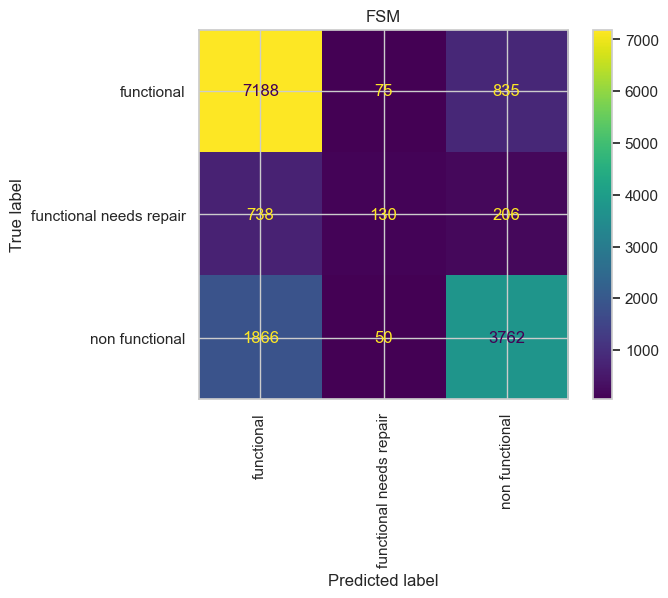

In [39]:
plot_confusion_matrix(lr, X_test_fin, y_test)
plt.title('FSM')
plt.xticks(rotation='vertical');

#### Coefficients of Features

In [40]:
coef = pd.DataFrame(lr.coef_, columns = X_test_fin.columns).transpose()

In [41]:
pd.set_option('display.max_rows', 500)
# coef

### Refining our Data

#### Using Smote to Deal with Class Imbalance

In [42]:
y_train.value_counts()

functional                 24161
non functional             17146
functional needs repair     3243
Name: status_group, dtype: int64

In [43]:
print("Before OverSampling, counts of label 'functional needs repair': {}".format(sum(y_train == 'functional needs repair'))) 
print("Before OverSampling, counts of label 'functional': {}".format(sum(y_train == 'functional'))) 
print("Before OverSampling, counts of label 'non functional': {} \n".format(sum(y_train == 'non functional'))) 
  
# import SMOTE module from imblearn library 
# pip install imblearn (if you don't have imblearn in your system) 
sm = SMOTE(random_state = 42) 
X_train_res, y_train_res = sm.fit_sample(X_train_fin, y_train.ravel()) 

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape)) 

print("After OverSampling, counts of label 'functional needs repair': {}".format(sum(y_train_res == 'functional needs repair'))) 
print("After OverSampling, counts of label 'functional': {}".format(sum(y_train_res == 'functional'))) 
print("After OverSampling, counts of label 'non functional': {}".format(sum(y_train_res == 'non functional')))

Before OverSampling, counts of label 'functional needs repair': 3243
Before OverSampling, counts of label 'functional': 24161
Before OverSampling, counts of label 'non functional': 17146 

After OverSampling, the shape of train_X: (72483, 304)
After OverSampling, the shape of train_y: (72483,) 

After OverSampling, counts of label 'functional needs repair': 24161
After OverSampling, counts of label 'functional': 24161
After OverSampling, counts of label 'non functional': 24161


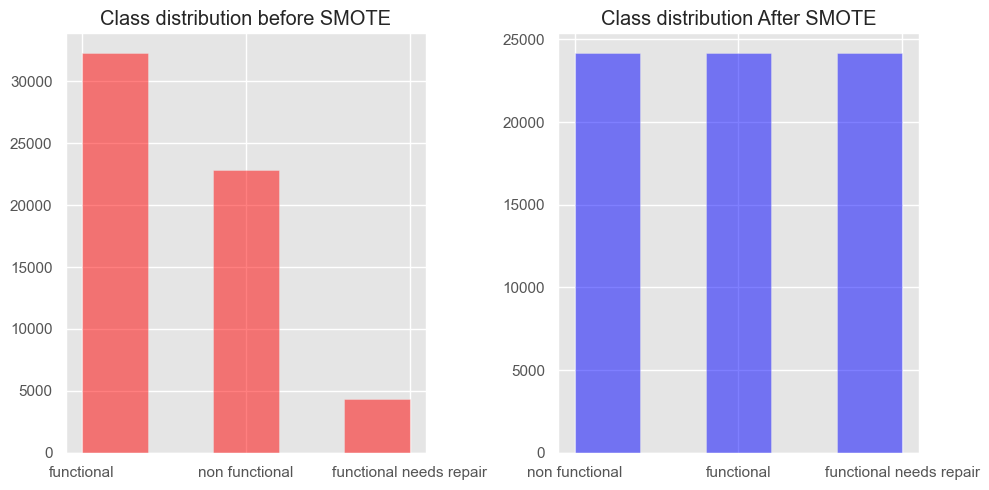

In [44]:
sns.set_context("notebook")
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5)) 
ax1.hist(y, color = 'red', alpha = .5, bins = 5)
ax1.set_title('Class distribution before SMOTE')
ax2.hist(y_train_res, color = 'blue', alpha = .5, bins = 5)
ax2.set_title('Class distribution After SMOTE')
fig.tight_layout();

#### Model After Smote

In [45]:
lr2 = LogisticRegression(max_iter=1000, random_state = 42)
lr2.fit(X_train_res, y_train_res)

LogisticRegression(max_iter=1000, random_state=42)

In [46]:
# Score on our training data
y_pred = lr2.predict(X_train_res)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.64      0.64      0.64     24161
functional needs repair       0.65      0.74      0.69     24161
         non functional       0.76      0.66      0.71     24161

               accuracy                           0.68     72483
              macro avg       0.68      0.68      0.68     72483
           weighted avg       0.68      0.68      0.68     72483



In [47]:
# Score on our testing data
y_pred = lr2.predict(X_test_fin)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.80      0.63      0.71      8098
functional needs repair       0.21      0.71      0.32      1074
         non functional       0.76      0.65      0.70      5678

               accuracy                           0.64     14850
              macro avg       0.59      0.66      0.58     14850
           weighted avg       0.75      0.64      0.68     14850



Our accuracy is now more even across classes, especially on the training data. However on the testing data, while the recall score soared, the precision score plummeted? The f1 score is still not great on the testing data either but really improved on the training data for class "functional needs repair". Considering our model is working much better on our training data than our testing data, we could use regularization techniques to avoid overfitting.

#### Dealing with Multicollinearity
Some investigators use correlation coefficients cutoffs of 0.5 and above but most typical cutoff is 0.80

In [48]:
# heheX_train_res, y_train_res, X_test_fin, y_test

In [49]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(X_train_res, 50))

Top Absolute Correlations
extraction_type_mono                extraction_type_group_mono               1.000000
extraction_type_other               extraction_type_class_other              1.000000
quantity_unknown                    quantity_group_unknown                   1.000000
extraction_type_nira/tanira         extraction_type_group_nira/tanira        1.000000
waterpoint_type_hand pump           waterpoint_type_group_hand pump          1.000000
waterpoint_type_cattle trough       waterpoint_type_group_cattle trough      1.000000
extraction_type_other - rope pump   extraction_type_group_rope pump          1.000000
extraction_type_group_gravity       extraction_type_class_gravity            1.000000
source_type_other                   source_class_unknown                     1.000000
water_quality_milky                 quality_group_milky                      1.000000
source_rainwater harvesting         source_type_rainwater harvesting         1.000000
payment_never pay           

In [50]:
top_corrs = get_top_abs_correlations(X_train_res, 47) #Dropping columns with correlation of 1

In [51]:
features_to_drop = [pair[1] for pair in top_corrs.index]

In [52]:
len(features_to_drop)

47

In [53]:
# Remove Duplicates from list
features_to_drop = list(dict.fromkeys(features_to_drop))
len(features_to_drop)

43

In [54]:
X_train_res.shape

(72483, 304)

In [55]:
X_train_res.drop(features_to_drop, axis=1, inplace=True)

In [56]:
X_train_res.shape

(72483, 261)

In [57]:
X_test_fin.shape

(14850, 304)

In [58]:
X_test_fin.drop(features_to_drop, axis=1, inplace=True)

In [59]:
X_test_fin.shape

(14850, 261)

In [60]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(X_train_res, 3))

Top Absolute Correlations
source_class_groundwater  source_class_surface               0.991114
extraction_type_mono      extraction_type_class_motorpump    0.977748
water_quality_fluoride    quality_group_fluoride             0.970055
dtype: float64


#### Feature Selection

In [61]:
#use inbuilt class feature_importances of tree based classifiers
model = ExtraTreesClassifier()
model.fit(X_train_res,y_train_res)

ExtraTreesClassifier()

In [62]:
# print(model.feature_importances_) 
feature_importance_df = pd.DataFrame(model.feature_importances_, index=X_train_res.columns).sort_values(by = 0, ascending = False)
feature_importance_df.head(10)

0
longitude              0.112968
latitude               0.111452
quantity_dry           0.052673
gps_height             0.052185
construction_year      0.042128
population             0.038452
quantity_enough        0.025901
quantity_insufficient  0.019470
payment_never pay      0.017177
extraction_type_other  0.016558

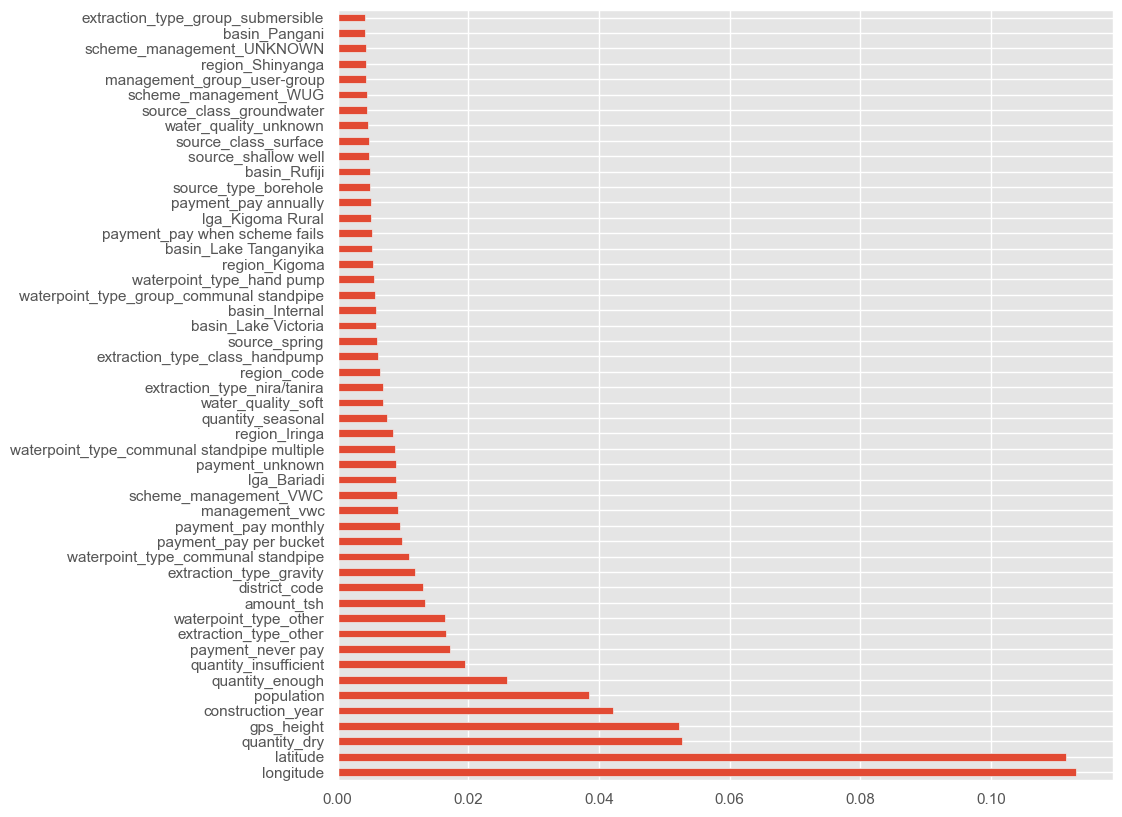

In [63]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X_train_res.columns)
fig = plt.subplots(figsize = (10,10))
feat_importances.nlargest(50).plot(kind='barh')
plt.show();

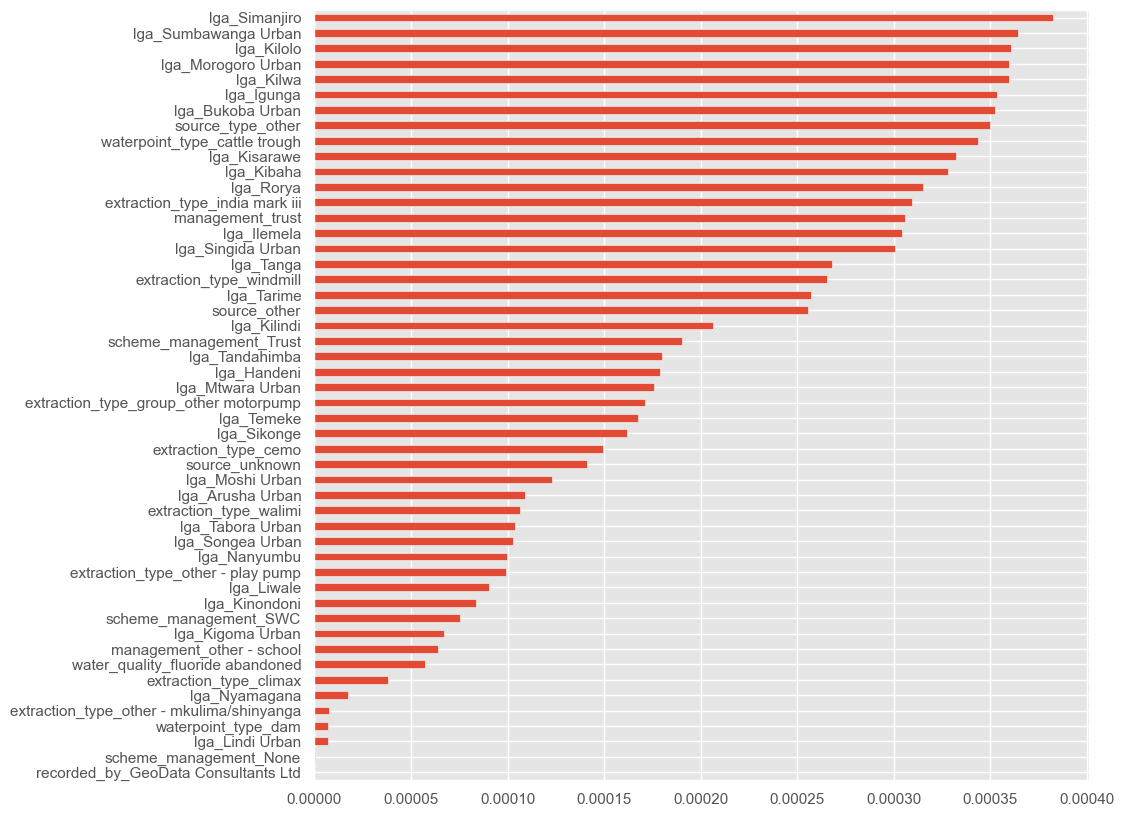

In [64]:
fig = plt.subplots(figsize = (10,10))
feat_importances.nsmallest(50).plot(kind='barh');


#### Filtered feature selection

In [65]:
print('Feature count: ', X_train_res.shape[1])

Feature count:  261


In [66]:
# Filter training and testing data with largest features
# Decided to use them all lol
X_train_filt = X_train_res[feat_importances.nlargest(261).index]
X_test_filt = X_test_fin[feat_importances.nlargest(261).index]

In [92]:
print('Feature count: ', X_train_filt.shape[1])

Feature count:  261


Model is working best when we use all the features

### Modeling with our Refined Data

Using hyperparameters from Andrew's tuning

In [93]:
# X_train_filt
# y_train_res
# X_test_filt
# y_test

#### Logistic Regression

In [94]:
lr3 = LogisticRegression(C=10, max_iter=1000, tol=10, random_state=42)
lr3.fit(X_train_filt, y_train_res)

LogisticRegression(C=10, max_iter=1000, random_state=42, tol=10)

In [95]:
# Score on our training data
y_pred = lr3.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.64      0.64      0.64     24161
functional needs repair       0.65      0.74      0.69     24161
         non functional       0.76      0.66      0.71     24161

               accuracy                           0.68     72483
              macro avg       0.68      0.68      0.68     72483
           weighted avg       0.68      0.68      0.68     72483



In [96]:
# Score on our testing data
y_pred = lr3.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.80      0.63      0.71      8098
functional needs repair       0.21      0.71      0.32      1074
         non functional       0.77      0.65      0.70      5678

               accuracy                           0.64     14850
              macro avg       0.59      0.66      0.58     14850
           weighted avg       0.75      0.64      0.68     14850



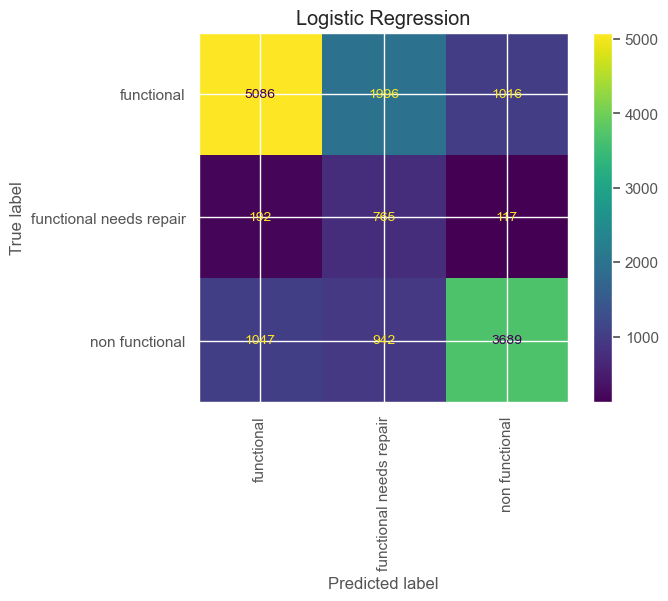

In [97]:
plot_confusion_matrix(lr3, X_test_filt, y_test)
plt.title('Logistic Regression')
plt.xticks(rotation='vertical');

#### KNN

In [98]:
knn1 = KNeighborsClassifier(n_neighbors = 5, p=1, weights='distance')
knn1.fit(X_train_filt, y_train_res)

KNeighborsClassifier(p=1, weights='distance')

In [99]:
# Score on our training data
y_pred = knn1.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.98      1.00      0.99     24161
functional needs repair       1.00      0.98      0.99     24161
         non functional       1.00      1.00      1.00     24161

               accuracy                           0.99     72483
              macro avg       0.99      0.99      0.99     72483
           weighted avg       0.99      0.99      0.99     72483



In [100]:
# Score on our testing data
y_pred = knn1.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.81      0.78      0.79      8098
functional needs repair       0.34      0.51      0.41      1074
         non functional       0.78      0.76      0.77      5678

               accuracy                           0.75     14850
              macro avg       0.64      0.68      0.66     14850
           weighted avg       0.77      0.75      0.76     14850



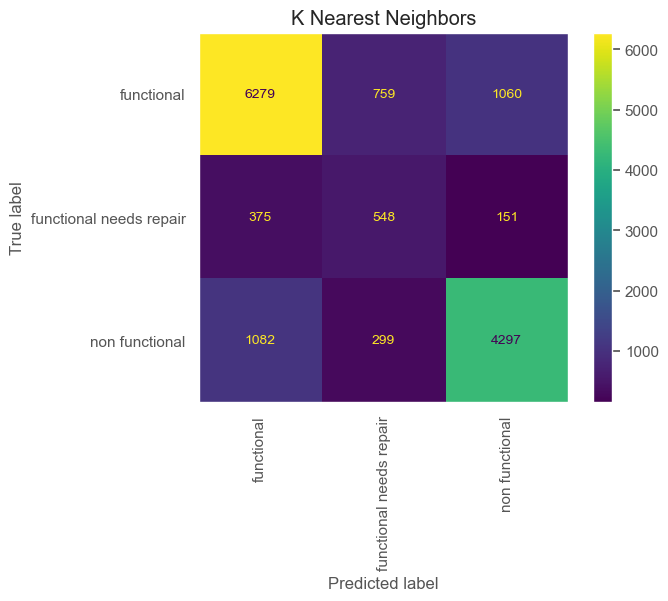

In [101]:
plot_confusion_matrix(knn1, X_test_filt, y_test)
plt.title('K Nearest Neighbors')
plt.xticks(rotation='vertical')
plt.grid();

#### Decision Tree

In [102]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_filt, y_train_res)

DecisionTreeClassifier(random_state=42)

In [103]:
# Score on our training data
y_pred = dt.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       1.00      0.99      0.99     24161
functional needs repair       0.99      1.00      0.99     24161
         non functional       1.00      1.00      1.00     24161

               accuracy                           1.00     72483
              macro avg       1.00      1.00      1.00     72483
           weighted avg       1.00      1.00      1.00     72483



In [104]:
# Score on our testing data
y_pred = dt.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.80      0.77      0.79      8098
functional needs repair       0.33      0.46      0.38      1074
         non functional       0.77      0.76      0.76      5678

               accuracy                           0.74     14850
              macro avg       0.63      0.66      0.64     14850
           weighted avg       0.76      0.74      0.75     14850



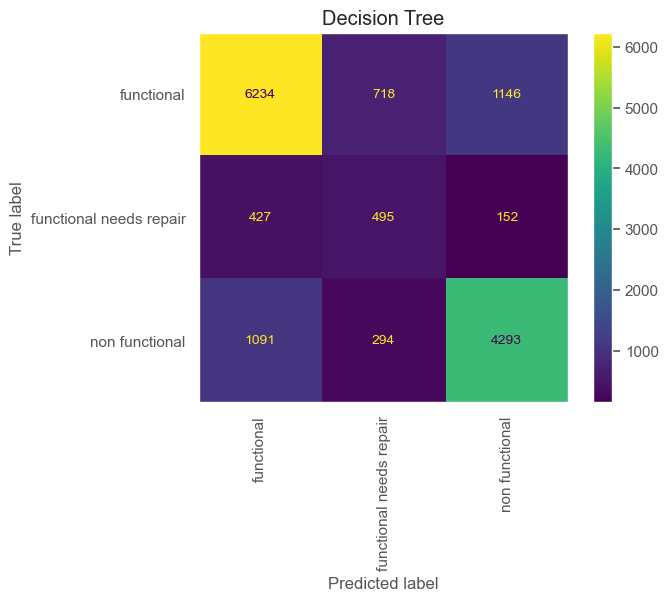

In [105]:
plot_confusion_matrix(dt, X_test_filt, y_test)
plt.title('Decision Tree')
plt.xticks(rotation='vertical')
plt.grid();

#### SVC

In [106]:
# svm = SVC(kernel='linear', decision_function_shape='ovo', random_state=42)
# svm.fit(X_train_filt, y_train_res)

In [107]:
# # Score on our training data
# y_pred = svm.predict(X_train_filt)
# print(classification_report(y_train_res, y_pred))

In [108]:
# # Score on our testing data
# y_pred = svm.predict(X_test_filt)
# print(classification_report(y_test, y_pred))

## Ensemble Methods

Voting and Averaging are "weak" estimators. They are useful in the case that the models are already accurate

#### Voting Ensemble

To explain the idealogy behind voting ensembles, I'll start with an analagy. In a game show like who wants to be a millionare, a contestant can choose to "ask the audience". The contestant usually chooses the answer most voted for by the audience. According to stats from TV studios, the audience chooses the right answer over 90% of the time. This is due to a concept known as "wisdom of the crowds" referring to the collective intelligence of a group being superior to a single expert. Voting Ensembles use wisdom of the crowds to make its prediction based on the mode (or majority prediction) of multiple individual models.


Boosting is another ensemble method based on iterative learning and sequential model building
Light Gradient Boost was Released by Microsoft in 2017
Optimized for parallel and GPU processing.
Useful for big datasets. Uses Regresion trees.

In [109]:
#Base estimators
# lr3 - linear regression model
# knn1 - knn model
# dt - decision tree model
# etc - extra trees classifier model

clf_voting = VotingClassifier(
    estimators = [
        ('linear regression', lr3),
        ('K Nearest Neighbors', knn1),
        ('Decision Tree', dt)])

In [110]:
clf_voting.fit(X_train_filt, y_train_res)

VotingClassifier(estimators=[('linear regression',
                              LogisticRegression(C=10, max_iter=1000,
                                                 random_state=42, tol=10)),
                             ('K Nearest Neighbors',
                              KNeighborsClassifier(p=1, weights='distance')),
                             ('Decision Tree',
                              DecisionTreeClassifier(random_state=42))])

In [111]:
# Score on our training data
y_pred = clf_voting.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.99      0.99      0.99     24161
functional needs repair       0.99      1.00      0.99     24161
         non functional       1.00      1.00      1.00     24161

               accuracy                           1.00     72483
              macro avg       1.00      1.00      1.00     72483
           weighted avg       1.00      1.00      1.00     72483



In [112]:
# Score on our testing data
y_pred = clf_voting.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.81      0.80      0.81      8098
functional needs repair       0.34      0.54      0.42      1074
         non functional       0.82      0.75      0.78      5678

               accuracy                           0.76     14850
              macro avg       0.66      0.70      0.67     14850
           weighted avg       0.78      0.76      0.77     14850



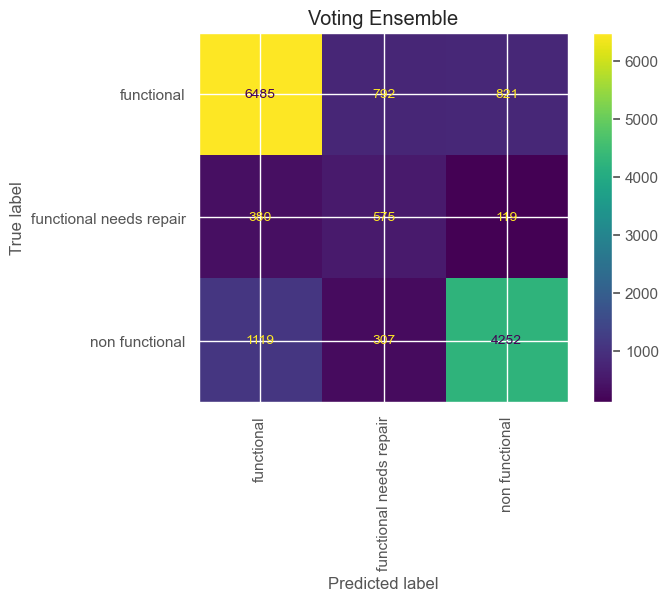

In [113]:
plot_confusion_matrix(clf_voting, X_test_filt, y_test)
plt.title('Voting Ensemble')
plt.xticks(rotation='vertical');

#### Averaging Classifier

In [114]:
#Base estimators
# lr3 - linear regression model
# knn1 - knn model
# dt - decision tree model
# etc - extra trees classifier model

clf_averaging = VotingClassifier(
    estimators = [
        ('linear regression', lr3),
        ('K Nearest Neighbors', knn1),
        ('Decision Tree', dt)],
    voting = 'soft',
)
clf_averaging.fit(X_train_filt, y_train_res)

VotingClassifier(estimators=[('linear regression',
                              LogisticRegression(C=10, max_iter=1000,
                                                 random_state=42, tol=10)),
                             ('K Nearest Neighbors',
                              KNeighborsClassifier(p=1, weights='distance')),
                             ('Decision Tree',
                              DecisionTreeClassifier(random_state=42))],
                 voting='soft')

In [115]:
# Score on our training data
y_pred = clf_averaging.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       1.00      0.99      0.99     24161
functional needs repair       0.99      1.00      0.99     24161
         non functional       1.00      1.00      1.00     24161

               accuracy                           1.00     72483
              macro avg       1.00      1.00      1.00     72483
           weighted avg       1.00      1.00      1.00     72483



In [116]:
# Score on our testing data
y_pred = clf_averaging.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.82      0.79      0.80      8098
functional needs repair       0.34      0.51      0.41      1074
         non functional       0.80      0.76      0.78      5678

               accuracy                           0.76     14850
              macro avg       0.65      0.69      0.66     14850
           weighted avg       0.78      0.76      0.77     14850



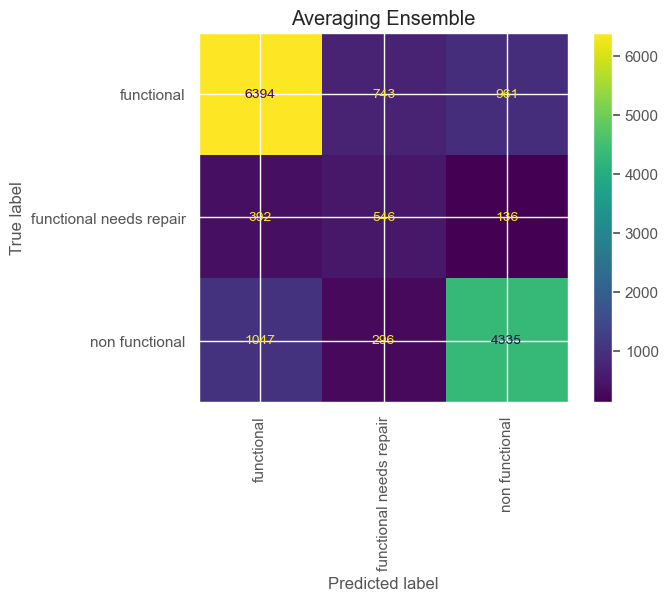

In [117]:
plot_confusion_matrix(clf_averaging, X_test_filt, y_test)
plt.title('Averaging Ensemble')
plt.xticks(rotation='vertical');

#### Extra Trees Classifier

In [118]:
# etc = ExtraTreesClassifier()
# etc.fit(X_train_filt,y_train_res)

In [119]:
# # Score on our training data
# y_pred = etc.predict(X_train_filt)
# print(classification_report(y_train_res, y_pred))

In [120]:
# # Score on our testing data
# y_pred = etc.predict(X_test_filt)
# print(classification_report(y_test, y_pred))

#### Random Forest Classifier

In [121]:
rfc = RandomForestClassifier(n_estimators=2000, random_state=42)
rfc.fit(X_train_filt,y_train_res)

RandomForestClassifier(n_estimators=2000, random_state=42)

In [122]:
# Score on our training data
y_pred = rfc.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       1.00      0.99      0.99     24161
functional needs repair       0.99      1.00      0.99     24161
         non functional       1.00      1.00      1.00     24161

               accuracy                           1.00     72483
              macro avg       1.00      1.00      1.00     72483
           weighted avg       1.00      1.00      1.00     72483



In [123]:
# Score on our testing data
y_pred = rfc.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.82      0.82      0.82      8098
functional needs repair       0.40      0.49      0.44      1074
         non functional       0.82      0.78      0.80      5678

               accuracy                           0.78     14850
              macro avg       0.68      0.70      0.69     14850
           weighted avg       0.79      0.78      0.79     14850



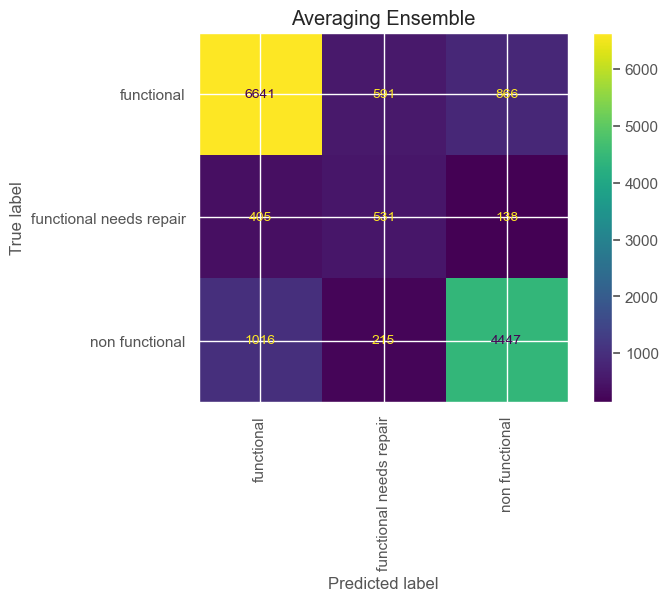

In [124]:
plot_confusion_matrix(rfc, X_test_filt, y_test)
plt.title('Averaging Ensemble')
plt.xticks(rotation='vertical');

#### Bagging Classifier Random Forest

Note Bagging is computationally expensive as it uses cross validation and will take time to run

For classification, the optimal value of max_features lies around the square root of the number of features. The square root of 250 is 15.8.

In [125]:
# # Setting max_features to 35 after some trial and error. The square root of number of features didnt seem to work well
# b_rf_clf = BaggingClassifier(RandomForestClassifier(n_estimators=2000, random_state=42), n_estimators = 30, max_features=30, random_state=42)
# b_rf_clf.fit(X_train_filt,y_train_res)

In [126]:
# # Score on our training data
# y_pred = b_rf_clf.predict(X_train_filt)
# print(classification_report(y_train_res, y_pred))

In [127]:
# # Score on our testing data
# y_pred = b_rf_clf.predict(X_test_filt)
# print(classification_report(y_test, y_pred))

In [128]:
# plot_confusion_matrix(b_rf_clf, X_test_filt, y_test)
# plt.title('Averaging Ensemble')
# plt.xticks(rotation='vertical');

GridSearch on Bagging Classifier

In [129]:
# grid = {"max_samples": [0.5, 1.0],
#         "bootstrap": [True, False],
#         "bootstrap_features": [True, False]}

# b_rf_clf = GridSearchCV(BaggingClassifier(RandomForestClassifier(max_depth=25), n_estimators = 10, max_features = 35),
#                         param_grid = grid)

Do not run the following cells again, takes a very long time and best params are just the default -_-

In [130]:
# b_rf_clf.fit(X_train_filt,y_train_res)

In [131]:
# b_rf_clf.best_params_
# 'bootstrap': True, 'bootstrap_features': False, 'max_samples': 1.0

### Boosting Algorithms
Based on iterative learning and sequential model building.
Good choice when problems are complex, need to apply parallel processing, have big data sets

#### Ada Boost Classifier

In [132]:
# Instantiate an AdaBoostClassifier
# Defaults are estimator=DecisionTree, n_estimator=100, learning_rate = 1
adaboost_clf = AdaBoostClassifier(n_estimators=100, random_state=42)
adaboost_clf.fit(X_train_filt, y_train_res)

AdaBoostClassifier(n_estimators=100, random_state=42)

In [133]:
# Score on our training data
y_pred = adaboost_clf.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.64      0.66      0.65     24161
functional needs repair       0.66      0.74      0.70     24161
         non functional       0.75      0.63      0.68     24161

               accuracy                           0.68     72483
              macro avg       0.68      0.68      0.68     72483
           weighted avg       0.68      0.68      0.68     72483



In [134]:
# Score on our testing data
y_pred = adaboost_clf.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.78      0.65      0.71      8098
functional needs repair       0.20      0.63      0.30      1074
         non functional       0.77      0.63      0.69      5678

               accuracy                           0.64     14850
              macro avg       0.58      0.64      0.57     14850
           weighted avg       0.73      0.64      0.67     14850



#### Gradient Boosting Classifier

In [135]:
# Instantiate an GradientBoostingClassifier
# We dont specify an estimator since Gradient Boosting uses regression trees
# Default params: n_estimators=100, learning_rate=0.1, mex_depth=3, min_samples_split, min_samples_leaf, max_features
# In Gradient Boosting, it is recommended to use all the features
gbt_clf = GradientBoostingClassifier(random_state=42)
gbt_clf.fit(X_train_filt, y_train_res)

GradientBoostingClassifier(random_state=42)

In [136]:
# Score on our training data
y_pred = gbt_clf.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.67      0.74      0.70     24161
functional needs repair       0.72      0.80      0.76     24161
         non functional       0.83      0.65      0.73     24161

               accuracy                           0.73     72483
              macro avg       0.74      0.73      0.73     72483
           weighted avg       0.74      0.73      0.73     72483



In [137]:
# Score on our testing data
y_pred = gbt_clf.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.78      0.73      0.75      8098
functional needs repair       0.24      0.63      0.34      1074
         non functional       0.82      0.63      0.71      5678

               accuracy                           0.69     14850
              macro avg       0.61      0.66      0.60     14850
           weighted avg       0.75      0.69      0.71     14850



#### Extreme Gradient Boosting Classifier

Optomized for distributed computing. Parallel training.

In [138]:
xgbc = xgb.XGBClassifier(max_depth=10, random_state=42)
xgbc.fit(X_train_filt,y_train_res)

XGBClassifier(max_depth=10, objective='multi:softprob', random_state=42)

In [139]:
# Score on our training data
y_pred = xgbc.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.83      0.83      0.83     24161
functional needs repair       0.84      0.94      0.88     24161
         non functional       0.91      0.80      0.85     24161

               accuracy                           0.86     72483
              macro avg       0.86      0.86      0.85     72483
           weighted avg       0.86      0.86      0.85     72483



In [140]:
# Score on our testing data
y_pred = xgbc.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.82      0.78      0.80      8098
functional needs repair       0.31      0.62      0.41      1074
         non functional       0.84      0.73      0.78      5678

               accuracy                           0.75     14850
              macro avg       0.65      0.71      0.66     14850
           weighted avg       0.79      0.75      0.76     14850



#### Light Gradient Boosting

Released by Microsoft in 2017
Fast and efficient. Lighter in terms of space.
Optimized for parallel and GPU processing.
Useful for big datasets.

In [141]:
# Params similar to gradient boosting except default max_depth = -1 (unlimited)
clf_lgb = lgb.LGBMClassifier(n_estimators=1000, seed=42)
clf_lgb.fit(X_train_filt,y_train_res)

LGBMClassifier(n_estimators=1000, seed=42)

In [142]:
# Score on our training data
y_pred = clf_lgb.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.90      0.90      0.90     24161
functional needs repair       0.92      0.97      0.94     24161
         non functional       0.95      0.90      0.92     24161

               accuracy                           0.92     72483
              macro avg       0.92      0.92      0.92     72483
           weighted avg       0.92      0.92      0.92     72483



In [143]:
# Score on our testing data
y_pred = clf_lgb.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.83      0.82      0.82      8098
functional needs repair       0.38      0.53      0.44      1074
         non functional       0.82      0.77      0.80      5678

               accuracy                           0.78     14850
              macro avg       0.68      0.71      0.69     14850
           weighted avg       0.79      0.78      0.79     14850



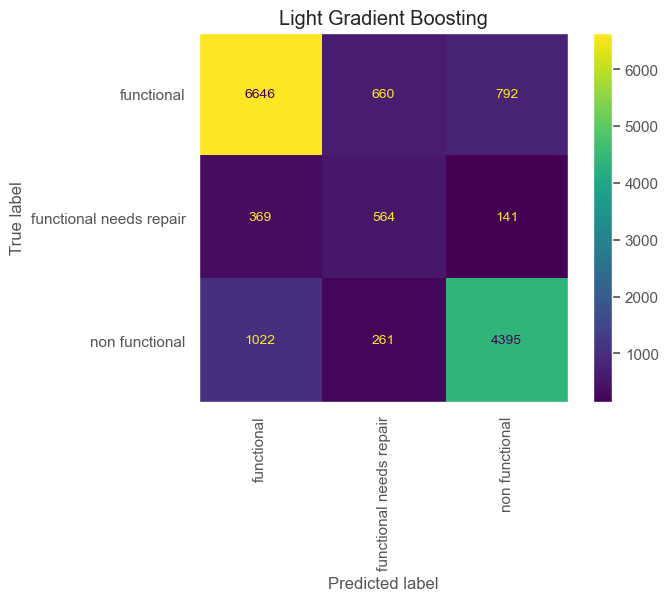

In [144]:
plot_confusion_matrix(clf_lgb, X_test_filt, y_test)
plt.title('Light Gradient Boosting')
plt.xticks(rotation='vertical')
plt.grid();

#### Cat Boost
Open sourced by Yandex(april 2017). Built in handling of categorical features. Accurate and robust. Fast and scalable

In [160]:
# Default Params - n_estimators=1000, learning_rate=0.1, max_depth=3, 
# reg_cat = cb.CatBoostClassifier(random_state=500)
# reg_cat.fit(X_train_filt, y_train_res)

In [146]:
# Score on our training data
y_pred = reg_cat.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.80      0.81      0.80     24161
functional needs repair       0.84      0.91      0.87     24161
         non functional       0.88      0.79      0.83     24161

               accuracy                           0.84     72483
              macro avg       0.84      0.84      0.84     72483
           weighted avg       0.84      0.84      0.84     72483



In [147]:
# Score on our testing data
y_pred = reg_cat.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.82      0.78      0.80      8098
functional needs repair       0.32      0.59      0.41      1074
         non functional       0.82      0.74      0.78      5678

               accuracy                           0.75     14850
              macro avg       0.65      0.71      0.66     14850
           weighted avg       0.79      0.75      0.77     14850



### Stacking

Combining models together. Good choice when Voting/Averaging dont have great results

In [149]:
# Parameters = classifiers = [clf1, clf2, clf3...], meta_classifiers=clf_meta, use_probas=False, use_features_in_secondary=False
classifiers = [lr3, knn1, dt, clf_voting, clf_averaging, rfc, adaboost_clf, gbt_clf, xgbc, clf_lgb, reg_cat]

clf_meta = clf_lgb

clf_stack = StackingClassifier(classifiers, clf_meta, use_features_in_secondary=True)

Target classes need to be numerical for StackingClassifier to work. Use Label Encoder for this

In [150]:
le = LabelEncoder()
le.fit(y_train_res)

LabelEncoder()

In [151]:
y_train_le = le.fit_transform(y_train_res)
y_test_le = le.transform(y_test)

In [152]:
clf_stack.fit(X_train_filt, y_train_le)

Learning rate set to 0.098445
0:	learn: 1.0599262	total: 74.1ms	remaining: 1m 14s
1:	learn: 1.0295639	total: 139ms	remaining: 1m 9s
2:	learn: 1.0049966	total: 200ms	remaining: 1m 6s
3:	learn: 0.9840931	total: 274ms	remaining: 1m 8s
4:	learn: 0.9663138	total: 337ms	remaining: 1m 7s
5:	learn: 0.9511214	total: 413ms	remaining: 1m 8s
6:	learn: 0.9380311	total: 476ms	remaining: 1m 7s
7:	learn: 0.9248354	total: 538ms	remaining: 1m 6s
8:	learn: 0.9139396	total: 607ms	remaining: 1m 6s
9:	learn: 0.9041168	total: 676ms	remaining: 1m 6s
10:	learn: 0.8966812	total: 733ms	remaining: 1m 5s
11:	learn: 0.8887911	total: 798ms	remaining: 1m 5s
12:	learn: 0.8818173	total: 868ms	remaining: 1m 5s
13:	learn: 0.8748605	total: 926ms	remaining: 1m 5s
14:	learn: 0.8685288	total: 990ms	remaining: 1m 5s
15:	learn: 0.8625278	total: 1.07s	remaining: 1m 5s
16:	learn: 0.8576061	total: 1.13s	remaining: 1m 5s
17:	learn: 0.8531163	total: 1.2s	remaining: 1m 5s
18:	learn: 0.8469465	total: 1.27s	remaining: 1m 5s
19:	learn:

162:	learn: 0.6264027	total: 10.5s	remaining: 54s
163:	learn: 0.6258500	total: 10.6s	remaining: 53.9s
164:	learn: 0.6251360	total: 10.6s	remaining: 53.9s
165:	learn: 0.6242971	total: 10.7s	remaining: 53.8s
166:	learn: 0.6235130	total: 10.8s	remaining: 53.7s
167:	learn: 0.6228305	total: 10.8s	remaining: 53.6s
168:	learn: 0.6224105	total: 10.9s	remaining: 53.6s
169:	learn: 0.6216970	total: 11s	remaining: 53.5s
170:	learn: 0.6209867	total: 11s	remaining: 53.4s
171:	learn: 0.6200780	total: 11.1s	remaining: 53.4s
172:	learn: 0.6195699	total: 11.2s	remaining: 53.3s
173:	learn: 0.6189283	total: 11.2s	remaining: 53.2s
174:	learn: 0.6184672	total: 11.3s	remaining: 53.2s
175:	learn: 0.6177591	total: 11.3s	remaining: 53.1s
176:	learn: 0.6172675	total: 11.4s	remaining: 53s
177:	learn: 0.6164506	total: 11.5s	remaining: 52.9s
178:	learn: 0.6158806	total: 11.5s	remaining: 52.8s
179:	learn: 0.6153943	total: 11.6s	remaining: 52.7s
180:	learn: 0.6147719	total: 11.6s	remaining: 52.7s
181:	learn: 0.614270

321:	learn: 0.5499165	total: 20.8s	remaining: 43.7s
322:	learn: 0.5496572	total: 20.8s	remaining: 43.7s
323:	learn: 0.5492728	total: 20.9s	remaining: 43.6s
324:	learn: 0.5490477	total: 21s	remaining: 43.6s
325:	learn: 0.5488163	total: 21s	remaining: 43.5s
326:	learn: 0.5485026	total: 21.1s	remaining: 43.5s
327:	learn: 0.5482302	total: 21.2s	remaining: 43.4s
328:	learn: 0.5480316	total: 21.3s	remaining: 43.3s
329:	learn: 0.5478402	total: 21.3s	remaining: 43.3s
330:	learn: 0.5474011	total: 21.4s	remaining: 43.2s
331:	learn: 0.5470320	total: 21.4s	remaining: 43.2s
332:	learn: 0.5467837	total: 21.5s	remaining: 43.1s
333:	learn: 0.5464162	total: 21.6s	remaining: 43s
334:	learn: 0.5461324	total: 21.7s	remaining: 43s
335:	learn: 0.5458038	total: 21.7s	remaining: 42.9s
336:	learn: 0.5453292	total: 21.8s	remaining: 42.9s
337:	learn: 0.5449217	total: 21.8s	remaining: 42.8s
338:	learn: 0.5446788	total: 21.9s	remaining: 42.7s
339:	learn: 0.5444058	total: 22s	remaining: 42.7s
340:	learn: 0.5441635	

480:	learn: 0.5087469	total: 31.6s	remaining: 34.1s
481:	learn: 0.5085640	total: 31.7s	remaining: 34.1s
482:	learn: 0.5084038	total: 31.8s	remaining: 34s
483:	learn: 0.5082738	total: 31.8s	remaining: 33.9s
484:	learn: 0.5080418	total: 31.9s	remaining: 33.9s
485:	learn: 0.5078257	total: 32s	remaining: 33.8s
486:	learn: 0.5076791	total: 32s	remaining: 33.8s
487:	learn: 0.5074050	total: 32.1s	remaining: 33.7s
488:	learn: 0.5072232	total: 32.2s	remaining: 33.6s
489:	learn: 0.5070330	total: 32.3s	remaining: 33.6s
490:	learn: 0.5068585	total: 32.3s	remaining: 33.5s
491:	learn: 0.5064951	total: 32.4s	remaining: 33.4s
492:	learn: 0.5063661	total: 32.4s	remaining: 33.4s
493:	learn: 0.5062159	total: 32.5s	remaining: 33.3s
494:	learn: 0.5059843	total: 32.6s	remaining: 33.2s
495:	learn: 0.5057768	total: 32.6s	remaining: 33.2s
496:	learn: 0.5056382	total: 32.7s	remaining: 33.1s
497:	learn: 0.5054329	total: 32.8s	remaining: 33s
498:	learn: 0.5052849	total: 32.8s	remaining: 33s
499:	learn: 0.5048698	

640:	learn: 0.4799004	total: 42.2s	remaining: 23.6s
641:	learn: 0.4796799	total: 42.2s	remaining: 23.5s
642:	learn: 0.4795105	total: 42.3s	remaining: 23.5s
643:	learn: 0.4793572	total: 42.4s	remaining: 23.4s
644:	learn: 0.4791189	total: 42.4s	remaining: 23.4s
645:	learn: 0.4789448	total: 42.5s	remaining: 23.3s
646:	learn: 0.4788379	total: 42.6s	remaining: 23.2s
647:	learn: 0.4786324	total: 42.6s	remaining: 23.2s
648:	learn: 0.4783629	total: 42.7s	remaining: 23.1s
649:	learn: 0.4781713	total: 42.8s	remaining: 23s
650:	learn: 0.4779269	total: 42.9s	remaining: 23s
651:	learn: 0.4777411	total: 42.9s	remaining: 22.9s
652:	learn: 0.4776056	total: 43s	remaining: 22.8s
653:	learn: 0.4774274	total: 43.1s	remaining: 22.8s
654:	learn: 0.4773212	total: 43.1s	remaining: 22.7s
655:	learn: 0.4771601	total: 43.2s	remaining: 22.7s
656:	learn: 0.4769827	total: 43.3s	remaining: 22.6s
657:	learn: 0.4768733	total: 43.3s	remaining: 22.5s
658:	learn: 0.4767329	total: 43.4s	remaining: 22.5s
659:	learn: 0.4766

800:	learn: 0.4579803	total: 52.6s	remaining: 13.1s
801:	learn: 0.4578713	total: 52.7s	remaining: 13s
802:	learn: 0.4577495	total: 52.7s	remaining: 12.9s
803:	learn: 0.4575936	total: 52.8s	remaining: 12.9s
804:	learn: 0.4573989	total: 52.9s	remaining: 12.8s
805:	learn: 0.4572574	total: 52.9s	remaining: 12.7s
806:	learn: 0.4571986	total: 53s	remaining: 12.7s
807:	learn: 0.4570963	total: 53.1s	remaining: 12.6s
808:	learn: 0.4569735	total: 53.1s	remaining: 12.5s
809:	learn: 0.4568844	total: 53.2s	remaining: 12.5s
810:	learn: 0.4567394	total: 53.2s	remaining: 12.4s
811:	learn: 0.4566183	total: 53.3s	remaining: 12.3s
812:	learn: 0.4565461	total: 53.4s	remaining: 12.3s
813:	learn: 0.4564989	total: 53.4s	remaining: 12.2s
814:	learn: 0.4564119	total: 53.5s	remaining: 12.1s
815:	learn: 0.4562639	total: 53.6s	remaining: 12.1s
816:	learn: 0.4561421	total: 53.6s	remaining: 12s
817:	learn: 0.4559782	total: 53.7s	remaining: 11.9s
818:	learn: 0.4557926	total: 53.7s	remaining: 11.9s
819:	learn: 0.4556

959:	learn: 0.4402730	total: 1m 3s	remaining: 2.65s
960:	learn: 0.4401867	total: 1m 3s	remaining: 2.58s
961:	learn: 0.4400960	total: 1m 3s	remaining: 2.52s
962:	learn: 0.4400100	total: 1m 3s	remaining: 2.45s
963:	learn: 0.4399048	total: 1m 3s	remaining: 2.38s
964:	learn: 0.4398306	total: 1m 3s	remaining: 2.32s
965:	learn: 0.4397295	total: 1m 3s	remaining: 2.25s
966:	learn: 0.4396193	total: 1m 4s	remaining: 2.19s
967:	learn: 0.4395372	total: 1m 4s	remaining: 2.12s
968:	learn: 0.4393639	total: 1m 4s	remaining: 2.05s
969:	learn: 0.4392244	total: 1m 4s	remaining: 1.99s
970:	learn: 0.4391790	total: 1m 4s	remaining: 1.92s
971:	learn: 0.4391083	total: 1m 4s	remaining: 1.85s
972:	learn: 0.4390490	total: 1m 4s	remaining: 1.79s
973:	learn: 0.4389378	total: 1m 4s	remaining: 1.72s
974:	learn: 0.4388547	total: 1m 4s	remaining: 1.66s
975:	learn: 0.4387553	total: 1m 4s	remaining: 1.59s
976:	learn: 0.4386952	total: 1m 4s	remaining: 1.52s
977:	learn: 0.4385869	total: 1m 4s	remaining: 1.46s
978:	learn: 

StackingClassifier(classifiers=[LogisticRegression(C=10, max_iter=1000,
                                                   random_state=42, tol=10),
                                KNeighborsClassifier(p=1, weights='distance'),
                                DecisionTreeClassifier(random_state=42),
                                VotingClassifier(estimators=[('linear '
                                                              'regression',
                                                              LogisticRegression(C=10,
                                                                                 max_iter=1000,
                                                                                 random_state=42,
                                                                                 tol=10)),
                                                             ('K Nearest '
                                                              'Neighbors',
                             

In [153]:
# Score on our training data
y_pred = clf_stack.predict(X_train_filt)
print(classification_report(y_train_le, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     24161
           1       0.99      1.00      0.99     24161
           2       1.00      1.00      1.00     24161

    accuracy                           1.00     72483
   macro avg       1.00      1.00      1.00     72483
weighted avg       1.00      1.00      1.00     72483



In [154]:
# Score on our testing data
y_pred = clf_stack.predict(X_test_filt)
print(classification_report(y_test_le, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.77      0.79      8098
           1       0.35      0.53      0.42      1074
           2       0.78      0.76      0.77      5678

    accuracy                           0.75     14850
   macro avg       0.65      0.69      0.66     14850
weighted avg       0.77      0.75      0.76     14850



In [155]:
confusion_matrix(y_test_le, y_pred)

array([[6252,  792, 1054],
       [ 363,  567,  144],
       [1077,  264, 4337]], dtype=int64)

## Final Predictions

Preprocess unlabeled data set

In [269]:
unlabeled_df = pd.read_csv("../../references/test_set_values.csv", index_col = 'id')
unlabeled_df_geo = unlabeled_df[['longitude', 'latitude']]

In [270]:
# Deal with the NAs
unlabeled_df.drop(columns_with_na, axis=1, inplace=True)
unlabeled_df.drop(columns_with_specific_location_and_names, axis=1, inplace=True)
unlabeled_df.drop('date_recorded', axis=1, inplace=True)
unlabeled_df['scheme_management'] = unlabeled_df['scheme_management'].fillna("UNKNOWN")

# split data to cat and cont and geo
unlabeled_df_cat = unlabeled_df.select_dtypes(include='object')
unlabeled_df_cont = unlabeled_df.select_dtypes(exclude='object')

# Impute and scale cont, onehotencode cat
unlabeled_df_imp = pd.DataFrame(si.transform(unlabeled_df_cont),
                                index = unlabeled_df_cont.index, columns = unlabeled_df_cont.columns)
unlabeled_df_sc = pd.DataFrame(ss.transform(unlabeled_df_imp),
                               index = unlabeled_df_imp.index, columns = unlabeled_df_imp.columns)
unlabeled_df_ohe = pd.DataFrame(ohe.transform(unlabeled_df_cat),
                          columns = ohe.get_feature_names(unlabeled_df_cat.columns), index = unlabeled_df_cat.index)

# Join it back together
unlabeled_df = unlabeled_df_sc.join(unlabeled_df_ohe)

# 
unlabeled_df.drop(features_to_drop, axis=1, inplace=True)

In [271]:
unlabeled_df = unlabeled_df[X_train_filt.columns]

In [272]:
y_pred = xgbc.predict(unlabeled_df)

In [274]:
y_pred_df = pd.DataFrame(y_pred, index = unlabeled_df_geo.index)

In [275]:
final_df = pd.concat([unlabeled_df_geo, y_pred_df], axis=1)

In [276]:
final_df.head()

longitude   latitude               0
id                                         
50785  35.290799  -4.059696  non functional
51630  36.656709  -3.309214      functional
17168  34.767863  -5.004344      functional
45559  38.058046  -9.418672  non functional
49871  35.006123 -10.950412      functional

In [277]:
# Add a geometry column that holds Point objects with lat and long
final_df['geometry'] = final_df.apply(lambda x: Point(float(x.longitude), float(x.latitude)), axis=1)
final_df = gpd.GeoDataFrame(final_df, geometry='geometry')
final_df.crs = "EPSG:4326"
final_df = final_df.to_crs(epsg = 3857)

C:\Users\Sin City\anaconda3\envs\learn-env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [278]:
final_df.head()

longitude   latitude               0                          geometry
id                                                                           
50785  35.290799  -4.059696  non functional   POINT (3928553.797 -452301.957)
51630  36.656709  -3.309214      functional   POINT (4080606.172 -368585.025)
17168  34.767863  -5.004344      functional   POINT (3870340.822 -557790.719)
45559  38.058046  -9.418672  non functional  POINT (4236602.311 -1053236.143)
49871  35.006123 -10.950412      functional  POINT (3896863.837 -1226483.845)

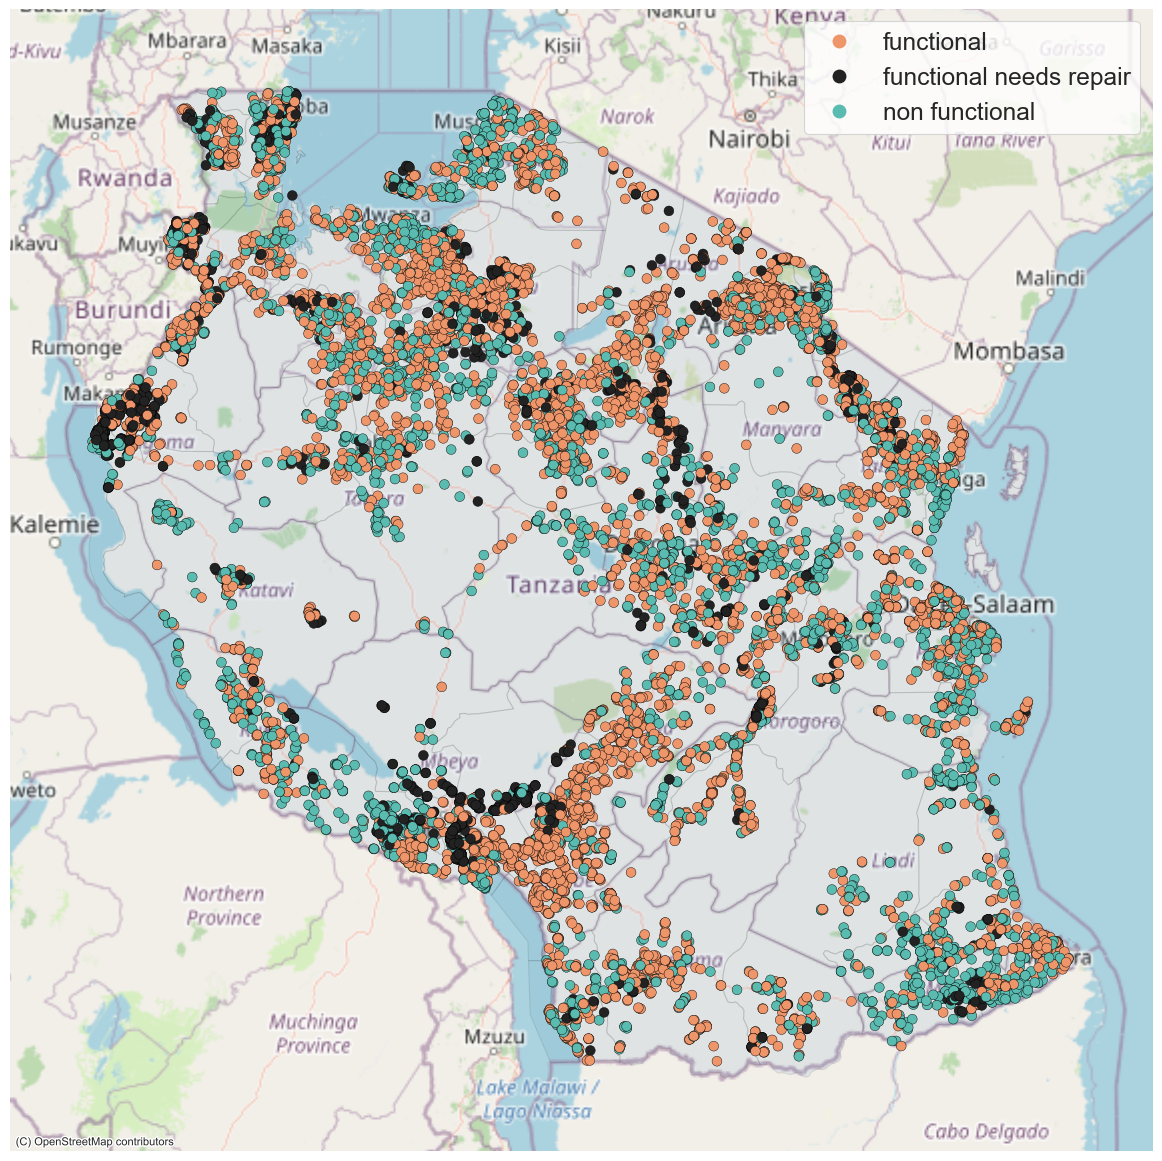

In [286]:
sns.set_context("paper", font_scale=2)
fig, ax = plt.subplots(figsize=(12,12))
geo_df.plot(ax=ax, color = 'steelblue', edgecolor = 'k', alpha = .1)

final_df.plot(ax=ax, column = 0, marker = '.', markersize=200,
         edgecolor = 'black', cmap = custom_palette,
         linewidth=.3, legend = True)

minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx-100000, maxx+100000)
ax.set_ylim(miny-100000, maxy+100000)

ctx.add_basemap(ax, source = ctx.providers.OpenStreetMap.Mapnik)#, source=ctx.providers.OpenStreetMap.Mapnik)
# plt.title('Tanzanian Water Wells', fontdict={'fontsize': '50', 'fontweight' : '10', 'color' : 'coral'})
ax.set_axis_off()
fig.tight_layout()
plt.savefig('../../reports/figures/Tanzania_final.jpg', dpi = 300);